In [45]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Arial'],#['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

import os
import sys
# 将上级目录添加到 sys.path
sys.path.append('./Step4_DNN-alldata')

import LSTM
import BLSTM_ATT

import shap
shap.initjs()

In [47]:
data = np.load('./Step4_DNN-alldata/databygroup.npy',allow_pickle=True).tolist()
#聚类筛选的数据，从step5-1中直接复制
TrainData,TestData={},{}
for k in data.keys():
    TrainData[k]=data[k]
    TestData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
xtrain,ytrain=[],[]
for k in TrainData.keys():
    for i in range(int(0.8*TrainData[k].shape[0])-step-1):
        xtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        ytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())
    #xtrain.append(xtem)
    #ytrain.append(ytem)
xtrain = torch.Tensor(xtrain)
ytrain = torch.Tensor(ytrain)
print(xtrain.shape,ytrain.shape)

torch.Size([34684, 20, 15]) torch.Size([34684, 5])


In [169]:
n1,n2 = 300,320 # 90-110 ok
X = xtrain[n1:n2].reshape((n2-n1,-1))
print(X.shape)

torch.Size([20, 300])


# 找到变换之后每个feature的编号

In [199]:
# inNH4,inTN,inflow,inCOD,inT,ANH4,ANO3,A-MLSS,AinDO,AoutDO,BNH4,BNO3,B-MLSS,BinDO,BoutDO

st = ['inNH4','inTN','inflow','inCOD','inT',
      'ANH4','ANO3','A-MLSS','AinDO','AoutDO',
      'BNH4','BNO3','B-MLSS','BinDO','BoutDO']

testdata = []
for _ in range(10):
    line = []
    for t in range(step):
        stt = st.copy()
        for it in range(len(stt)):
            stt[it] += str(t+1)
        line.append(stt)
    testdata.append(line)
testdata=np.array(testdata).reshape((10,-1))


#用这个查每个feature编号对应数据名字
testdata[0][68]

'AinDO5'

# ATT shap

In [171]:
modelid = '990'

In [172]:
# FD-ATT
param={
    'embedding_dim':xtrain.shape[2], 
    'num_hiddens':100, 
    'windowsize':xtrain.shape[1],
    'num_layers':4,
    'output_dim':ytrain.shape[1], 
    'learning_rate':0.0001,
    'opt':'Adam',
    }
net1 = BLSTM_ATT.Net(param)
net1 = torch.load('./Step4_DNN-alldata/model/BLSTM_ATT'+modelid+'.pth')
#net = torch.load('./Step4_DNN-augdata/model/LSTM490.pth')
#net = torch.load('./Step4_DNN-scenariodata/model/LSTM490.pth')

# 合并两个torch model，前一个是修改输入形状，后一个是已经训练好的模型

# 定义修改输入形状的模型
class InputShapeModifier(nn.Module):
    def __init__(self):
        super(InputShapeModifier, self).__init__()

    def forward(self, x):
        # 这里简单示例，可根据需求修改
        return x.view(-1, 
                      param['windowsize'],
                      param['embedding_dim']
                      )
    
input_modifier = InputShapeModifier()

# 合并模型
class CombinedModel(nn.Module):
    def __init__(self, input_modifier, trained_model):
        super(CombinedModel, self).__init__()
        self.input_modifier = input_modifier
        self.trained_model = trained_model

    def forward(self, x):
        x = self.input_modifier(x)
        x = self.trained_model(x)
        #x = x[0]
        return x
    
combined_model1 = CombinedModel(input_modifier, net1)
explainer1 = shap.DeepExplainer(combined_model1,X)
shap_values1 = explainer1.shap_values(X)

C:\Users\chong\AppData\Local\Temp\ipykernel_840\1553150798.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net1 = torch.load('./Step4_DNN-alldata/model/BLSTM_ATT'+model

In [173]:
# KD-LSTM
param={
    'embedding_dim':xtrain.shape[2], 
    'num_hiddens':100, 
    'windowsize':xtrain.shape[1],
    'num_layers':4,
    'output_dim':ytrain.shape[1], 
    'learning_rate':0.0001,
    'opt':'Adam',
    }
net2 = BLSTM_ATT.Net(param)
net2 = torch.load('./Step4_DNN-alldata/model/BLSTM_ATT'+modelid+'.pth')
#net = torch.load('./Step4_DNN-scenariodata/model/LSTM490.pth')

# 合并两个torch model，前一个是修改输入形状，后一个是已经训练好的模型

# 定义修改输入形状的模型
class InputShapeModifier(nn.Module):
    def __init__(self):
        super(InputShapeModifier, self).__init__()

    def forward(self, x):
        # 这里简单示例，可根据需求修改
        return x.view(-1, 
                      param['windowsize'],
                      param['embedding_dim']
                      )
    
input_modifier = InputShapeModifier()

# 合并模型
class CombinedModel(nn.Module):
    def __init__(self, input_modifier, trained_model):
        super(CombinedModel, self).__init__()
        self.input_modifier = input_modifier
        self.trained_model = trained_model

    def forward(self, x):
        x = self.input_modifier(x)
        x = self.trained_model(x)
        #x = x[0]
        return x
    
combined_model2 = CombinedModel(input_modifier, net2)
explainer2 = shap.DeepExplainer(combined_model2,X)
shap_values2 = explainer2.shap_values(X)

C:\Users\chong\AppData\Local\Temp\ipykernel_840\3345181175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2 = torch.load('./Step4_DNN-alldata/model/BLSTM_ATT'+model

In [174]:
# SC-LSTM
param={
    'embedding_dim':xtrain.shape[2], 
    'num_hiddens':100, 
    'windowsize':xtrain.shape[1],
    'num_layers':4,
    'output_dim':ytrain.shape[1], 
    'learning_rate':0.0001,
    'opt':'Adam',
    }
net3 = BLSTM_ATT.Net(param)
net3 = torch.load('./Step4_DNN-scenariodata/model/BLSTM_ATT'+modelid+'.pth')

# 合并两个torch model，前一个是修改输入形状，后一个是已经训练好的模型

# 定义修改输入形状的模型
class InputShapeModifier(nn.Module):
    def __init__(self):
        super(InputShapeModifier, self).__init__()

    def forward(self, x):
        # 这里简单示例，可根据需求修改
        return x.view(-1, 
                      param['windowsize'],
                      param['embedding_dim']
                      )
    
input_modifier = InputShapeModifier()

# 合并模型
class CombinedModel(nn.Module):
    def __init__(self, input_modifier, trained_model):
        super(CombinedModel, self).__init__()
        self.input_modifier = input_modifier
        self.trained_model = trained_model

    def forward(self, x):
        x = self.input_modifier(x)
        x = self.trained_model(x)
        #x = x[0]
        return x
    
combined_model3 = CombinedModel(input_modifier, net3)
explainer3 = shap.DeepExplainer(combined_model3,X)
shap_values3 = explainer3.shap_values(X)

C:\Users\chong\AppData\Local\Temp\ipykernel_840\1189158385.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net3 = torch.load('./Step4_DNN-scenariodata/model/BLSTM_ATT'+

In [135]:
# save shape value
np.save('./Result_shap/SHAP_FDATT.npy', shap_values1, allow_pickle=True)
np.save('./Result_shap/SHAP_KDATT.npy', shap_values2, allow_pickle=True)
np.save('./Result_shap/SHAP_SCATT.npy', shap_values3, allow_pickle=True)

# 使用shap_values直接作图

In [175]:
def fig_shap(shap_values,num,filename):
    # num: 前多少个feature
    mn = np.mean(np.abs(shap_values),axis=0)
    smn = np.sum(mn,axis=1)
    ssmn = np.sort(smn)[::-1]
    index_ssmn = np.argsort(smn)[::-1]

    fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(15,6)
                )
    gs = GridSpec(1, 1, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure
    ax = fig.add_subplot(gs[0, 0])
    ax.bar([i for i in range(num)],ssmn[:num])
    ax.set_xticks([i for i in range(num)],index_ssmn[:num],fontsize=15)
    ax.tick_params(axis='y', labelsize=16)

    plt.savefig('./Result_shap/'+filename+'.png',dpi=300,bbox_inches='tight')

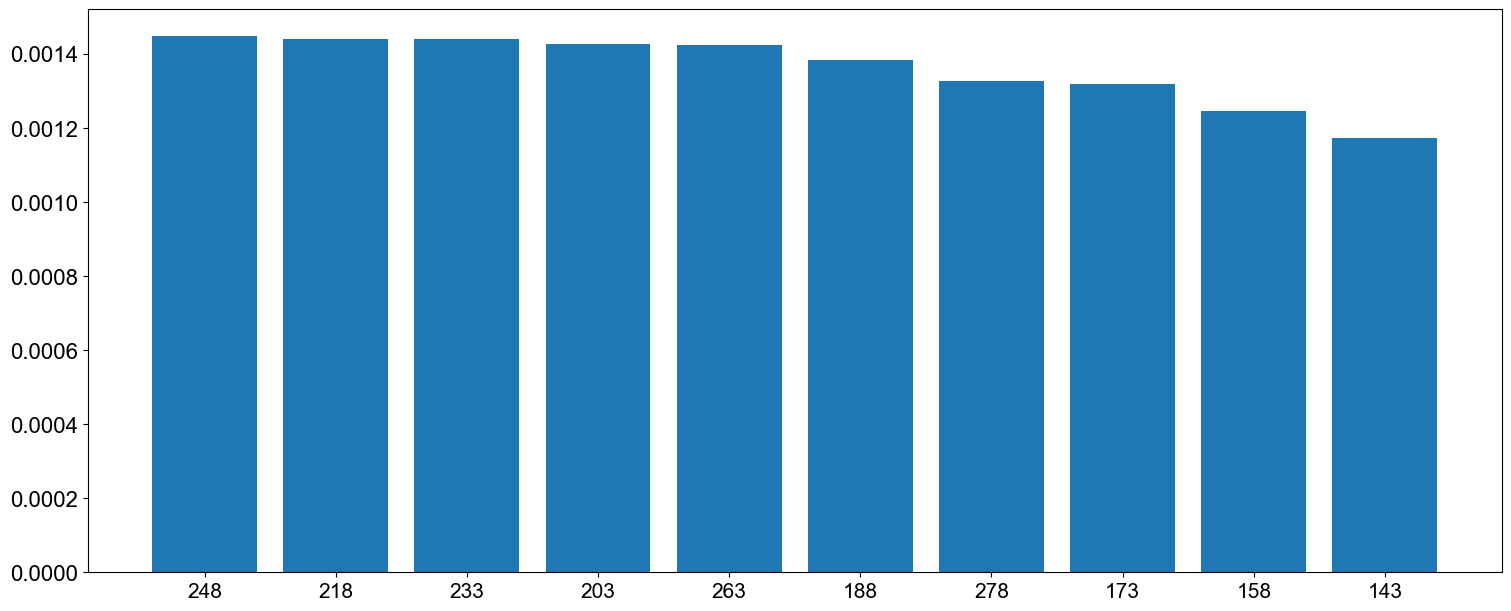

In [176]:
fig_shap(shap_values1,10,'FD-ATT')

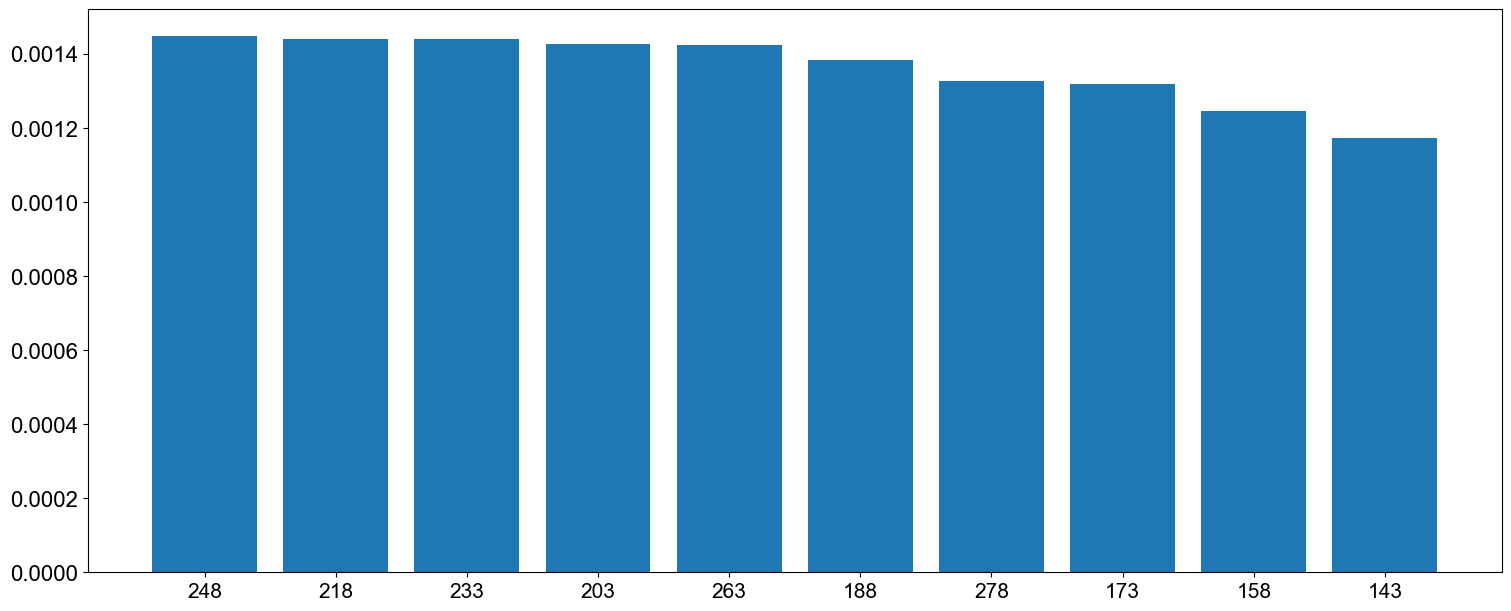

In [177]:
fig_shap(shap_values2,10,'KD-ATT')

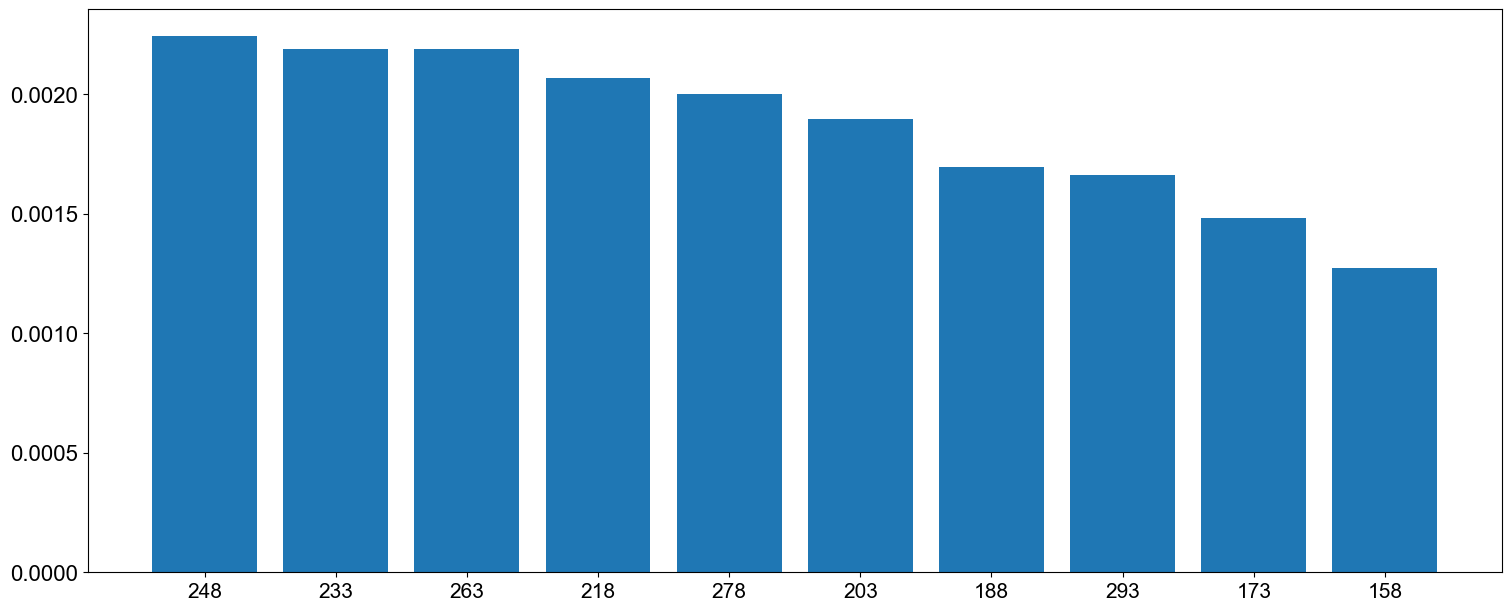

In [178]:
fig_shap(shap_values3,10,'SC-ATT')